In [1]:
# Install the Kaggle package
!pip install -q kaggle

# Create a folder for the Kaggle token file
!mkdir -p ~/.kaggle

# Copy the token from your uploaded file to the folder
!cp kaggle.json ~/.kaggle/

# Set the correct permissions for the file
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
# Replace 'badasstechie/celebahq-resized-256x256' with your specific dataset's ID
!kaggle datasets download -d arjuntejaswi/plant-village

Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
 97%|███████████████████████████████████████▋ | 318M/329M [00:02<00:00, 107MB/s]
100%|█████████████████████████████████████████| 329M/329M [00:03<00:00, 114MB/s]


In [9]:
# Unzip the dataset into a directory
!unzip "plant-village.zip" -d "dataset"


Archive:  plant-village.zip
  inflating: dataset/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG  
  inflating: dataset/PlantVillage/Pepper__bell___Bacterial_spot/006adb74-934f-448f-a14f-62181742127b___JR_B.Spot 3395.JPG  
  inflating: dataset/PlantVillage/Pepper__bell___Bacterial_spot/00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132.JPG  
  inflating: dataset/PlantVillage/Pepper__bell___Bacterial_spot/01613cd0-d3cd-4e96-945c-a312002037bf___JR_B.Spot 3262.JPG  
  inflating: dataset/PlantVillage/Pepper__bell___Bacterial_spot/0169b9ac-07b9-4be1-8b85-da94481f05a4___NREC_B.Spot 9169.JPG  
  inflating: dataset/PlantVillage/Pepper__bell___Bacterial_spot/018e494e-d2eb-468b-9d02-40219d9f4921___JR_B.Spot 9045.JPG  
  inflating: dataset/PlantVillage/Pepper__bell___Bacterial_spot/01940b6d-7dea-4889-a7b8-a35f4e9bba34___NREC_B.Spot 9120.JPG  
  inflating: dataset/PlantVillage/Pepper__bell___Bacterial_spot/01dfb88b-cd5a-420c-b163-51f5fe07b74d

In [27]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [28]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [29]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [30]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [31]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[14  9 14  6  3  0  7  6  3 11  9  8  5  3  3  5  5  9 10  6 14 14  2  2
 14  6  5  2  9 12  2  8]


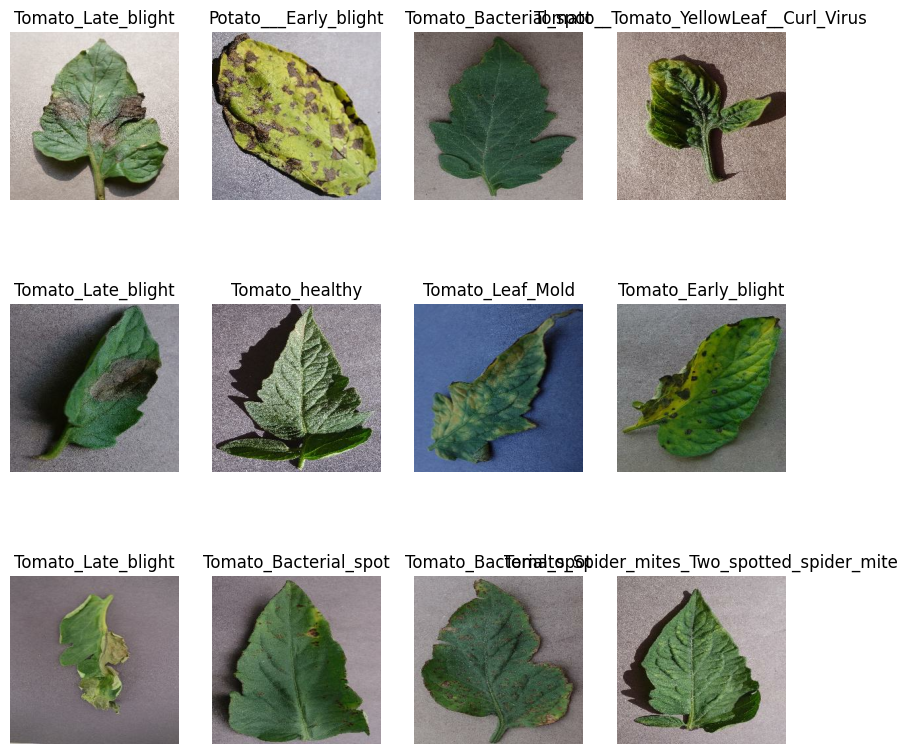

In [32]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [33]:
len(dataset)

645

In [34]:
train_size = 0.8
len(dataset)*train_size

516.0

In [35]:
train_ds = dataset.take(516)
len(train_ds)

516

In [36]:
test_ds = dataset.skip(516)
len(test_ds)

129

In [37]:
val_size=0.1
len(dataset)*val_size

64.5

In [38]:
val_ds = test_ds.take(64)
len(val_ds)

64

In [39]:
test_ds = test_ds.skip(64)
len(test_ds)

65

In [40]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [41]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [42]:
len(train_ds)

516

In [43]:
len(val_ds)

64

In [44]:
len(test_ds)

65

In [45]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [46]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [47]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [48]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [49]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [50]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [52]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
516/516 [==============================] - 76s 140ms/step - loss: 2.0217 - accuracy: 0.3355 - val_loss: 1.4624 - val_accuracy: 0.5039
Epoch 2/50
516/516 [==============================] - 70s 135ms/step - loss: 1.1642 - accuracy: 0.6109 - val_loss: 1.1749 - val_accuracy: 0.6270
Epoch 3/50
516/516 [==============================] - 70s 136ms/step - loss: 0.8092 - accuracy: 0.7277 - val_loss: 0.7797 - val_accuracy: 0.7383
Epoch 4/50
516/516 [==============================] - 70s 136ms/step - loss: 0.6211 - accuracy: 0.7852 - val_loss: 0.8256 - val_accuracy: 0.7334
Epoch 5/50
516/516 [==============================] - 71s 137ms/step - loss: 0.5146 - accuracy: 0.8229 - val_loss: 0.7554 - val_accuracy: 0.7603
Epoch 6/50
516/516 [==============================] - 71s 138ms/step - loss: 0.4517 - accuracy: 0.8447 - val_loss: 0.4377 - val_accuracy: 0.8477
Epoch 7/50
516/516 [==============================] - 70s 136ms/step - loss: 0.3952 - accuracy: 0.8639 - val_loss: 0.5339 - val_ac

In [53]:
scores = model.evaluate(test_ds)

65/65 [==============================] - 2s 11ms/step - loss: 0.2018 - accuracy: 0.9346


In [54]:
scores

[0.20177339017391205, 0.9346153736114502]

In [55]:
history

In [56]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 516}

In [57]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [58]:
type(history.history['loss'])

list

In [59]:
len(history.history['loss'])

50

In [60]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.0216968059539795,
 1.164197564125061,
 0.8091719746589661,
 0.6210517287254333,
 0.5146359205245972]

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

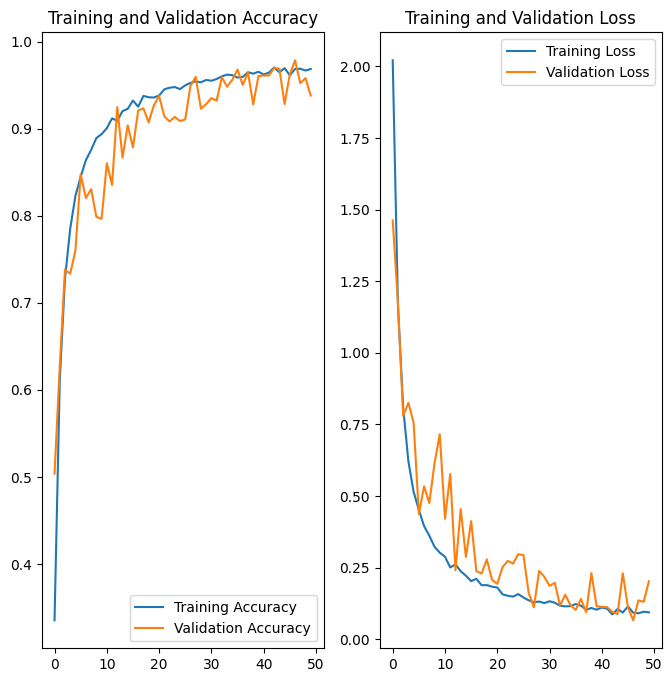

In [62]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato__Tomato_YellowLeaf__Curl_Virus
1/1 [==============================] - 0s 104ms/step
predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus


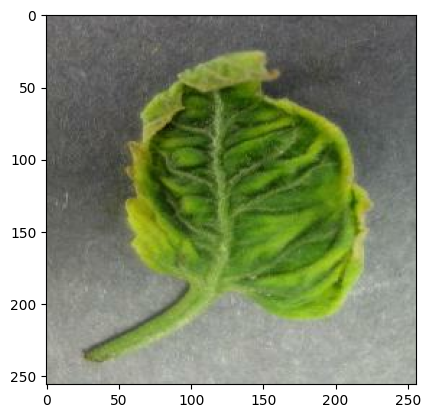

In [63]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [64]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


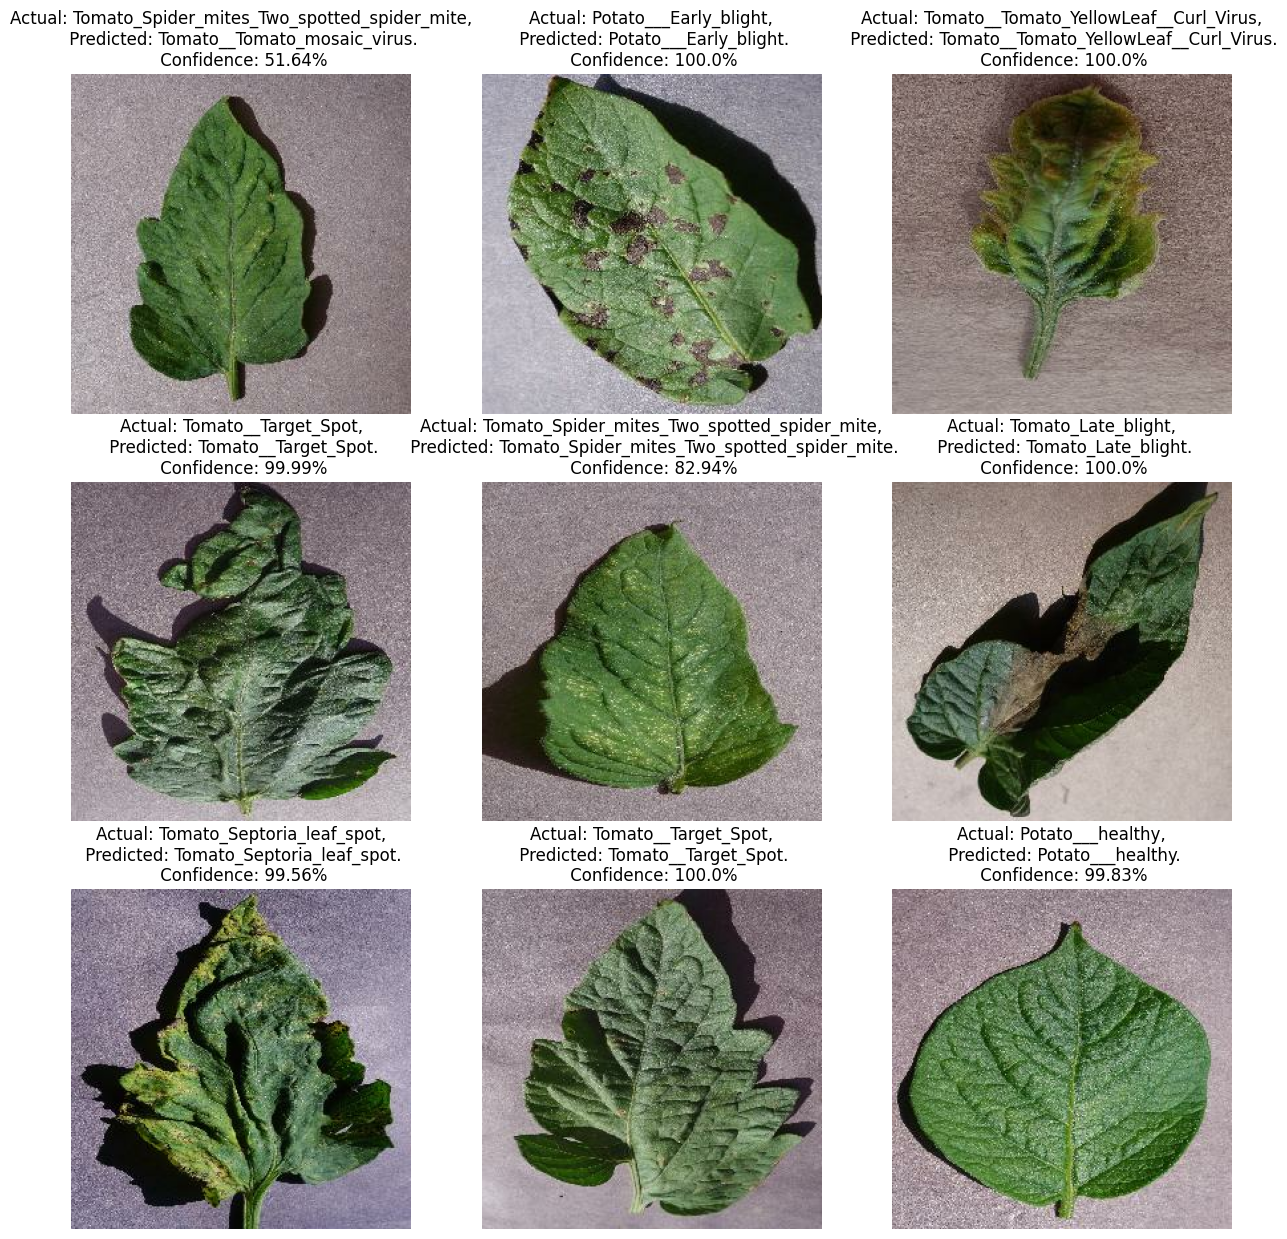

In [65]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [67]:
import os

# Ensure the models directory exists
os.makedirs("../models", exist_ok=True)

# Determine the next model version
model_version = max([int(i) for i in os.listdir("../models") if i.isdigit()] + [0]) + 1

# Save the model
model.save(f"../models/keshav.h5")


PermissionError: [Errno 13] Permission denied: '../models'